In [74]:

import os
import pandas as pd
import numpy as np
import glob
import plotnine as gg
import re
from plotnine import *
import matplotlib.pyplot as plt




In [92]:
figpath = '../Figures/ExpPHa07_1b/'

## Loading data

### Annotations csv file

In [76]:

anno = pd.read_csv('../data/ExpPHa07_1/annotations/ExpPHa07_1_b_2502.csv', skiprows=[0])

skipcolumns = [0,2,4,5,6]

d = (anno.drop(anno.columns[skipcolumns], axis=1)
     .rename(columns={'/Annotation/@Name': 'Annotation',
                      '/Annotation/#id': 'Id',
                      '/Annotation/Regions/Region/#id': 'Region_ID',
                      '/Annotation/Regions/Region/Vertices/V/@X': 'X',
                      '/Annotation/Regions/Region/Vertices/V/@Y': 'Y'})
    )



d['Image_ID'] = 'ExpPHa07_1_a'

d = d[['Image_ID','Region_ID','Annotation', 'X', 'Y']]


In [77]:
d.head()

,Image_ID,Region_ID,Annotation,X,Y
0,ExpPHa07_1_a,1,outline,9016,398
1,ExpPHa07_1_a,1,outline,9012,402
2,ExpPHa07_1_a,1,outline,9036,434
3,ExpPHa07_1_a,1,outline,9036,442
4,ExpPHa07_1_a,1,outline,9111,481


### Tissue data csv

In [79]:
data = pd.read_csv('../data/ExpPHa07_1/ExpPHa07_1_b.tif_2502_job2997.object_results.csv')

# Renaming of column names

data.columns = [col.replace(' ', '_') for col in data.columns]

## Extracting tissue image names from filenames

data['Image_Location'] = pd.DataFrame(data.loc[:, 'Image_Location']
                                      .str.split('\\')
                                      .str.get(9)
                                      .str.replace('.tif', ''))

data = (data
        .rename(columns={'Image_Location': 'Image_ID'})
        .drop(columns = ['Analysis_Region', 'Analysis_Inputs'])  
       )
data.head()

,Image_ID,Object_Id,XMin,XMax,YMin,YMax,Opal_520_Copies,Opal_520_Area_(µm²),Opal_520_Classification,Opal_520_Cell_Intensity,...,Opal_690_Copies,Opal_690_Area_(µm²),Opal_690_Classification,Opal_690_Cell_Intensity,Opal_690_Avg_Intensity,Cell_Area_(µm²),Cytoplasm_Area_(µm²),Nucleus_Area_(µm²),Nucleus_Perimeter_(µm),Nucleus_Roundness
0,ExpPHa07_1_b,0,1819,1837,1136,1155,5,2.459689,2,1.236106,...,0,0.0,0,0.0,0.0,54.60511,34.68162,19.92348,19.34215,0.716581
1,ExpPHa07_1_b,1,1809,1825,1137,1157,0,0.000000,0,0.000000,...,0,0.0,0,0.0,0.0,59.27851,41.32278,17.95573,17.35834,0.717423
2,ExpPHa07_1_b,2,1977,1995,1139,1152,0,0.000000,0,0.000000,...,0,0.0,0,0.0,0.0,47.22604,34.68162,12.54442,13.39072,0.839642
3,ExpPHa07_1_b,3,1894,1911,1140,1157,0,0.000000,0,0.000000,...,0,0.0,0,0.0,0.0,42.55263,30.74612,11.80651,14.87858,0.684001
4,ExpPHa07_1_b,4,1753,1770,1143,1167,11,4.427441,3,2.354090,...,0,0.0,0,0.0,0.0,75.75844,57.31076,18.44767,18.84620,0.650195


### Function to Calculate Centroids of the rectangular bounding boxes

### Note:
### 1st step: calculating center of detected objects by calculating center of bounding boxes

In [80]:
# Use the height and width to calculate the area
def X_centroid(row):
    X = int(row['XMin'] + row['XMax'])/2

    return int(X)

def Y_centroid(row):
    Y = int(row['YMin'] + row['YMax'])/2
    return int(Y)

data['X'] = data.apply(X_centroid, axis=1)
data['Y'] = data.apply(Y_centroid, axis=1)


### Function of Cell Classification

In [81]:
def classification(row):
    
    if (row['Opal_520_Classification'] >= 3) & (row['Opal_570_Classification'] < 2) & (row['Opal_620_Classification'] < 2) & (row['Opal_690_Classification'] < 2):
        return 'CM0'
    elif (row['Opal_520_Classification'] < 2) & (row['Opal_570_Classification'] >= 3) & (row['Opal_620_Classification'] < 2) & (row['Opal_690_Classification'] < 2):
        return 'CM4'
    elif (row['Opal_520_Classification'] == 0) & (row['Opal_570_Classification'] == 0) & (row['Opal_620_Classification'] >= 3) & (row['Opal_690_Classification'] == 0):
        return 'all'
    elif (row['Opal_520_Classification'] < 2) & (row['Opal_570_Classification'] < 2) & (row['Opal_620_Classification'] < 2) & (row['Opal_690_Classification'] >= 3):
        return 'CM1'
    else:
        return 'NC'
    
    

### Applying Classification Function

In [82]:
data['Classification'] = data.apply(classification, axis=1)

data['Classification'].unique()

array(['NC', 'CM0', 'CM4', 'CM1', 'all'], dtype=object)

In [90]:
glom_id = d.loc[d['Annotation'] == "gloms"]['Region_ID'].unique().tolist()
glom_id 

[2, 3, 4, 5, 6, 7, 8, 9, 10]

## Creating Mask 

### Note:
1) Annotated regions are filled using polygon function(Skimage)

2) Cell coordinates were matched with masked region and separate dataframe is generated

In [85]:
from skimage.draw import polygon


def Intersection(data, mask): 
    return set(dt).intersection(set(mask))

fmask = []

## Glomerulus Mask

glom_id = d.loc[d['Annotation'] == "gloms"]['Region_ID'].unique().tolist()
glom_label = ['gloms'] * len(glom_id)

gf = []
for p in glom_id:
    poly = d[(d.Annotation == 'gloms') & (d.Region_ID == p)]
    row, col = polygon(np.array(poly.X),
                         np.array(poly.Y))
    mask = [m for m in zip(row, col)]
    dt = [t for t in zip(data.X, data.Y)]
    d_mask = Intersection(dt,mask)
    g = pd.DataFrame(d_mask, columns=['X', 'Y'])
    g['mask'] = 'gloms'
    g['Region_ID'] = p
        
    gf.append(g)
gmask = pd.concat(gf)
    



### Vessels Mask

vessel_id = d.loc[d['Annotation'] == "vessels"]['Region_ID'].unique().tolist()
vessel_label = ['vessels'] * len(vessel_id)
vf = []

for p in vessel_id:
   
    poly = d[(d.Annotation == 'vessels') & (d.Region_ID == p)]
    row, col = polygon(np.array(poly.X),
                         np.array(poly.Y))
    mask = [m for m in zip(row, col)]
    dt = [t for t in zip(data.X, data.Y)]
    d_mask = Intersection(dt,mask)
    v = pd.DataFrame(d_mask, columns=['X', 'Y'])
    v['mask'] = 'vessels'
    v['Region_ID'] = p
        
    vf.append(v)
vmask= pd.concat(vf)


fmask = pd.DataFrame(gmask.append(vmask))    


In [11]:
# from skimage.draw import polygon


# def Intersection(data, mask): 
#     return set(dt).intersection(set(mask))


# labels = ['vessels', 'gloms', 'gloms']
# ID = [4,2,3]

      
# fmask = []
          

# for p, j in zip(labels, ID):
#     if p == "vessels" and j == 4:
#         poly = d[(d.Annotation == str(p)) & (d.Region_ID == j)]
#         row, col = polygon(np.array(poly.X),
#                          np.array(poly.Y))
#         mask = [m for m in zip(row, col)]
#         dt = [t for t in zip(data.X, data.Y)]
#         d_mask = Intersection(dt,mask)
#         v = pd.DataFrame(d_mask, columns=['X', 'Y'])
#         v['mask'] = str(p)
#         v['Region_ID'] = j
        
#     elif p == "gloms" and j == 2:
#         poly = d[(d.Annotation == str(p)) & (d.Region_ID == j)]
#         row, col = polygon(np.array(poly.X),
#                          np.array(poly.Y))
#         mask = [m for m in zip(row, col)]
#         dt = [t for t in zip(data.X, data.Y)]
#         d_mask = Intersection(dt,mask)
#         g1 = pd.DataFrame(d_mask, columns=['X', 'Y'])
#         g1['mask'] = str(p)
#         g1['Region_ID'] = j
    
#     elif p == "gloms" and j == 3:
#         poly = d[(d.Annotation == str(p))& (d.Region_ID == j)]
#         row, col = polygon(np.array(poly.X),
#                          np.array(poly.Y))
#         mask = [m for m in zip(row, col)]
#         dt = [t for t in zip(data.X, data.Y)]
#         d_mask = Intersection(dt,mask)
#         g2 = pd.DataFrame(d_mask, columns=['X', 'Y'])
#         g2['mask'] = str(p)
#         g2['Region_ID'] = j
        
  
# fmask = pd.DataFrame(v.append([g1, g2]))





### Merging of Dataframes and replacing NaN values with "No" for mask and Region_ID columns

In [86]:

final =  data.merge(fmask,how='left', on=['X', 'Y'])
(final['mask']
 .fillna('Out', inplace=True)
)
(final['Region_ID']
 .fillna(0, inplace=True)
)

In [87]:
final['Region_ID'].unique()

array([ 0.,  8.,  5.,  4.,  2.,  3.,  9., 11.,  7.,  6., 10.])

In [14]:
#test.to_csv('/Users/habbasi/Desktop/test.csv')
      

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 6.4 x 4.8 in image.
  warn("Saving {0} x {1} {2} image.".format(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../Figures/ExpPHa07_1b/Masked_tissue_Figure2.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


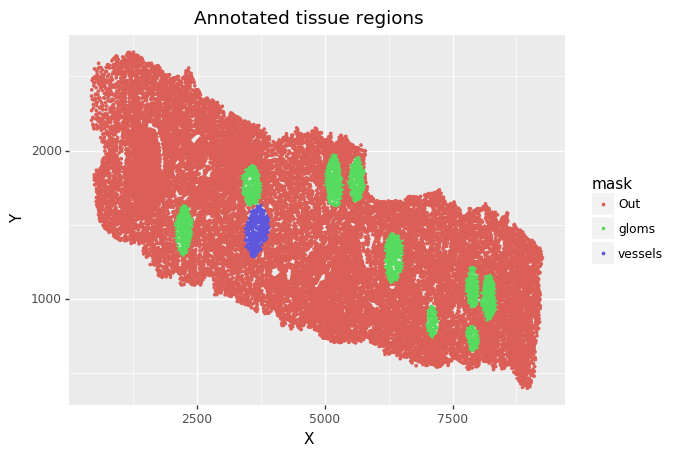

<ggplot: (297760190)>

In [94]:
#f = final[final['mask'] != "No"]

p = (
    ggplot(final)
    + geom_point(gg.aes(x='X', y='Y', color = 'mask'), size = 0.5) 
    + xlab("X") 
    + ylab("Y")
    + labs(title= 'Annotated tissue regions')
#     + scale_colour_manual(name= "Tissue compartment", 
#                            labels=['Outside','Glomerulus_2', 'Glomerulus_3', 'Glomerulus_3',], 
#                            values = ["#fde0ef","#e41a1c", "#984ea3","#1f78b4"])
    
)

ggsave(filename='Masked_tissue_Figure2.png', plot = p, path = figpath)

p


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 6.4 x 4.8 in image.
  warn("Saving {0} x {1} {2} image.".format(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../Figures/ExpPHa07_1b/Annotations_Figure1.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


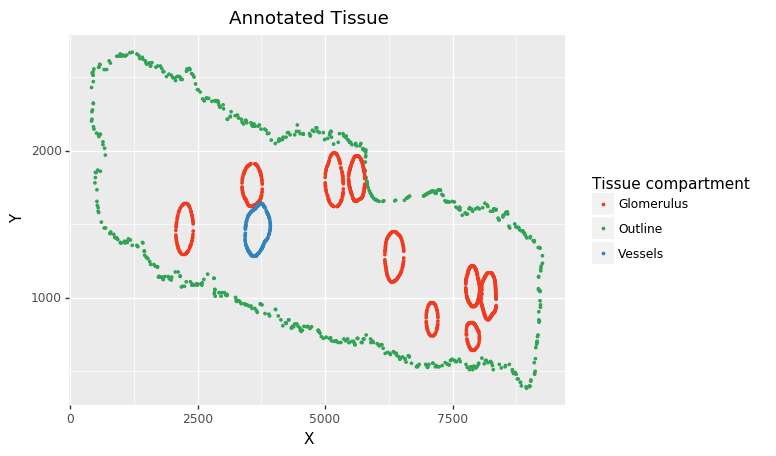

<ggplot: (985413455)>

In [95]:


p = (
    ggplot(d)
    + geom_point(gg.aes(x='X', y='Y', color='Annotation' ), size = 0.5) 
    + xlab("X") 
    + ylab("Y")
    + labs(title= 'Annotated Tissue')
    + scale_colour_manual(name= "Tissue compartment", 
                           labels=['Glomerulus', 'Outline', 'Vessels'], 
                           values = ["#f03b20", "#31a354", "#3182bd"])
    
)
ggsave(filename='Annotations_Figure1.png', plot = p, path = figpath)

p



In [96]:
final.head()

,Image_ID,Object_Id,XMin,XMax,YMin,YMax,Opal_520_Copies,Opal_520_Area_(µm²),Opal_520_Classification,Opal_520_Cell_Intensity,...,Cell_Area_(µm²),Cytoplasm_Area_(µm²),Nucleus_Area_(µm²),Nucleus_Perimeter_(µm),Nucleus_Roundness,X,Y,Classification,mask,Region_ID
0,ExpPHa07_1_b,0,1819,1837,1136,1155,5,2.459689,2,1.236106,...,54.60511,34.68162,19.92348,19.34215,0.716581,1828,1145,NC,Out,0.0
1,ExpPHa07_1_b,1,1809,1825,1137,1157,0,0.000000,0,0.000000,...,59.27851,41.32278,17.95573,17.35834,0.717423,1817,1147,NC,Out,0.0
2,ExpPHa07_1_b,2,1977,1995,1139,1152,0,0.000000,0,0.000000,...,47.22604,34.68162,12.54442,13.39072,0.839642,1986,1145,NC,Out,0.0
3,ExpPHa07_1_b,3,1894,1911,1140,1157,0,0.000000,0,0.000000,...,42.55263,30.74612,11.80651,14.87858,0.684001,1902,1148,NC,Out,0.0
4,ExpPHa07_1_b,4,1753,1770,1143,1167,11,4.427441,3,2.354090,...,75.75844,57.31076,18.44767,18.84620,0.650195,1761,1155,CM0,Out,0.0


### Count of various cell types in a tissue

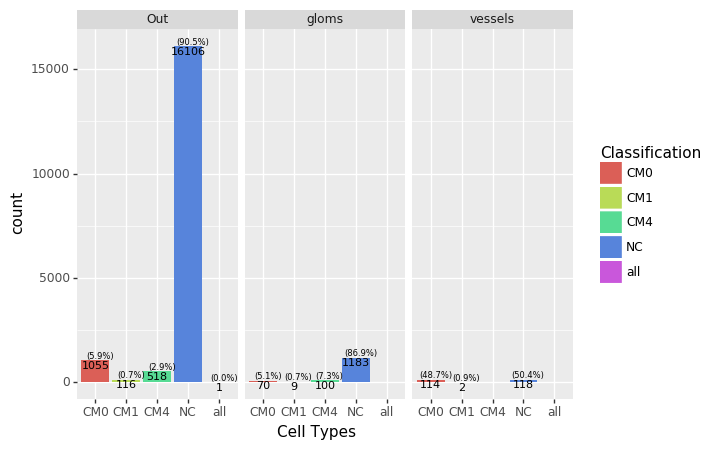

<ggplot: (282270495)>


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 6.4 x 4.8 in image.
  warn("Saving {0} x {1} {2} image.".format(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../Figures/ExpPHa07_1b/Cell_Count_various_compartments.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


In [99]:
# p = (
#     ggplot(final)
#     + geom_bar(aes(x='Classification', fill = 'Classification',  color= 'Classification'))
#     + theme_classic() 
#     + labs(title= "Tissue Specific Myleoid Cell-Subtype Count")
#     + geom_text(aes(label='stat(count)'), stat='count',nudge_y=0.125, va='bottom')
   
    
# )


# #print(p + facet_wrap('~ mask', nrow=2))
    
# p
    

#ggsave(filename='Cell_Count_Entire_tissue.png', plot = p, path = '../Figures/ExpPHa07_1/')


p = (ggplot(final, aes(x='Classification', fill = 'Classification'))
 + geom_bar()
 + geom_text(
     aes(label='stat(count)'),
     stat='count',
     nudge_x=-0.0,
     nudge_y=2,
     va='top',
     size=8)
 + xlab('Cell Types')
    
 + geom_text(
     aes(label='stat(prop)*100', group=1),
     stat='count',
     nudge_x=0.15,
     nudge_y=0.125,
     va='bottom',
     size=6,
     format_string='({:.1f}%)'
)

 )
g = p + facet_wrap('~ mask')
print(g)


ggsave(filename='Cell_Count_various_compartments.png', plot = g, path = figpath)


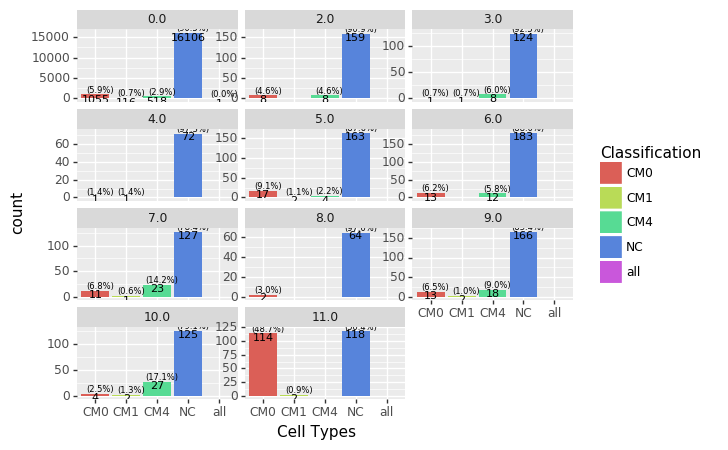

<ggplot: (955309659)>


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 6.4 x 4.8 in image.
  warn("Saving {0} x {1} {2} image.".format(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../Figures/ExpPHa07_1b/Cell_Count_various_Region_ID.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


In [110]:
p = (ggplot(final, aes(x='Classification', fill = 'Classification'))
 + geom_bar()
 + geom_text(
     aes(label='stat(count)'),
     stat='count',
     nudge_x=-0.0,
     nudge_y=2,
     va='top',
     size=8)
 + xlab('Cell Types')
    
 + geom_text(
     aes(label='stat(prop)*100', group=1),
     stat='count',
     nudge_x=0.15,
     nudge_y=0.125,
     va='bottom',
     size=6,
     format_string='({:.1f}%)'
)

 )
g = p + facet_wrap('~ Region_ID', nrow=5, scales="free_y")
print(g)


ggsave(filename='Cell_Count_various_Region_ID.png', plot = g, path = figpath)

### Plotting a Pie chart for total count of cell per tissue

In [307]:
# for i, p in enumerate(final['mask'].unique()):
#     comp = final.loc[final['mask'] == str(p)]
#     comp.groupby('Classification').size()
#     colors = ["#8856a7", "#de2d26", "#addd8e",'#43a2ca']
#     labels = comp['Classification'].unique()
#     values = comp['Classification'].value_counts(dropna=False)
#     fig = go.Pie(labels=labels, values=values, marker=dict(colors=colors, line=dict(color='#FFF', width=2)),
#                domain={'x': [0.0, 1], 'y': [0.0, 1]}, showlegend=False, name='Count of Cell types', textinfo='label+percent')
    
#     layout = go.Layout(height = 600,
#                    width = 1000,
#                    autosize = False,
#                    title = str(p))
    
#     fig = go.Figure(data = fig, layout = layout)
    
#     fig


    

    



### Plotting

In [117]:
tissuelist = final['mask'].unique()


for i, p in enumerate(tissuelist):
    
    dt = final.loc[final['mask'] == str(p)]
    
    g = gg.ggplot(dt, gg.aes(x='X', y='Y',color = "Classification")) + \
    gg.geom_point(size = 0.5) + \
    gg.xlab("X") + \
    gg.ylab("Y") #+ \
#     gg.scale_colour_manual(name= "Cell types", 
#                            labels=['CM0', 'CM1', 'CM4','all', 'NC'], 
#                            values = ["#f03b20", "#31a354", "#3182bd","#fee6ce", '#bababa']) + \
    gg.labs(title= 'Distribution of Cell Types_' +  str(p)) 
    ggsave(filename=str(p)+'.png', plot = g, path = figpath)
         
    
        





/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 6.4 x 4.8 in image.
  warn("Saving {0} x {1} {2} image.".format(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../Figures/ExpPHa07_1b/Out.png
  warn('Filename: {}'.format(filename), PlotnineWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 6.4 x 4.8 in image.
  warn("Saving {0} x {1} {2} image.".format(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../Figures/ExpPHa07_1b/gloms.png
  warn('Filename: {}'.format(filename), PlotnineWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 6.4 x 4.8 in image.
  warn("Saving {0} x {1} {2} image."

In [379]:
# import plotly
# import plotly.graph_objs as go
# from plotly import tools
# import psutil

# d = data.loc[data['Image_Location'] == 'ExpPHa07_1_a']
# d.groupby('Classification').size()

# colors = ['#fc9272','#ffff99', '#7fcdbb', '#beaed4', '#7fc97f']
# labels = d['Classification'].unique()
# values = d['Classification'].value_counts(dropna=False)

# fig = go.Pie(labels=labels, values=values, marker=dict(colors=colors, line=dict(color='#FFF', width=2)),
#                domain={'x': [0.0, 1], 'y': [0.0, 1]}, showlegend=False, name='Count of Cell types', textinfo='label+percent')
    

# layout = go.Layout(height = 600,
#                    width = 1000,
#                    autosize = False,
#                    title = 'ExpPHa07_1_a')




# fig = go.Figure(data = fig, layout = layout)
# fig


In [135]:
final['Region_ID']= final['Region_ID'].astype(int)

[2, 3, 4, 5, 6, 7, 8, 9, 10]

## Calculating Distances among cells

In [141]:
import math


glom_id = sorted(final.loc[final['mask'] == "gloms"]['Region_ID'].unique().tolist())

prf = []

for p in glom_id:
    df = final.loc[(final['mask'] == 'gloms') & (final['Region_ID'] == p)]
    Classification = []
    for i in df['Classification']:
        for j in df['Classification']:
            cl = [i, j]
            Classification.append(cl)
            
    mask = []
    for i in df['mask']:
        for j in df['mask']:
            m = [i, j]
            mask.append(m)
            
    Region_ID = []
    for i in df['Region_ID']:
        for j in df['Region_ID']:
            r = [i, j]
            Region_ID.append(r)
            
    X = list(df.X)       
    Y = list(df.Y)

    distance = []  
    for i in range(0, len(X)):
        for j in range(0, len(X)):
            dist = math.sqrt((X[j] - X[i])**2 + ((Y[j] - Y[i])**2)) * 0.495952562137432
            distance.append(dist)

       
    coordinates = []        
    for i in zip(df.X, df.Y):
        for j in zip(df.X, df.Y):
            cor = [i, j]
            coordinates.append(cor)
        
    obj = []        
    for i in range(0, len(df.Object_Id)):
        for j in range(0, len(df.Object_Id)):
            com_obj = [i, j]
            obj.append(com_obj)
        
    obj_id = pd.DataFrame(obj, columns=['objID_1', 'objID_2'])
    dist = pd.DataFrame(distance, columns=['Distance'])
    meta = pd.DataFrame(Classification, columns=['idx_1', 'idx_2'])
    cord = pd.DataFrame(coordinates, columns=['cord_1', 'cord_2'])
    mask = pd.DataFrame(mask, columns=['mask_1', 'mask_2'])
    RID = pd.DataFrame(Region_ID, columns=['RID_1', 'RID_2'])

    pf = pd.concat([obj_id, cord, meta,mask, RID, dist], axis =1)
    
    prf.append(pf)       
pm = pd.cn     
#fmask = pd.DataFrame(gmask.append(vmask))      
    

# df = final.loc[(final['mask'] == 'gloms') & (final['Region_ID'] == 3)]

# Classification = []
# for i in df['Classification']:
#     for j in df['Classification']:
#         cl = [i, j]
#         Classification.append(cl)

# mask = []
# for i in df['mask']:
#     for j in df['mask']:
#         m = [i, j]
#         mask.append(m)
        
# Region_ID = []
# for i in df['Region_ID']:
#     for j in df['Region_ID']:
#         r = [i, j]
#         Region_ID.append(r)


# X = list(df.X)       
# Y = list(df.Y)

# distance = []  
# for i in range(0, len(X)):
#     for j in range(0, len(X)):
#         dist = math.sqrt((X[j] - X[i])**2 + ((Y[j] - Y[i])**2)) * 0.495952562137432
#         distance.append(dist)

       
# coordinates = []        
# for i in zip(df.X, df.Y):
#     for j in zip(df.X, df.Y):
#         cor = [i, j]
#         coordinates.append(cor)
        
# obj = []        
# for i in range(0, len(df.Object_Id)):
#     for j in range(0, len(df.Object_Id)):
#         com_obj = [i, j]
#         obj.append(com_obj)
        

# obj_id = pd.DataFrame(obj, columns=['objID_1', 'objID_2'])
# dist = pd.DataFrame(distance, columns=['Distance'])
# meta = pd.DataFrame(Classification, columns=['idx_1', 'idx_2'])
# cord = pd.DataFrame(coordinates, columns=['cord_1', 'cord_2'])
# mask = pd.DataFrame(mask, columns=['mask_1', 'mask_2'])
# RID = pd.DataFrame(Region_ID, columns=['RID_1', 'RID_2'])

# prf = pd.concat([obj_id, cord, meta,mask, RID, dist], axis =1)

# prf.head()       
        

In [144]:
prf

[       objID_1  objID_2        cord_1        cord_2 idx_1 idx_2 mask_1 mask_2  \
 0            0        0   (8205, 857)   (8205, 857)    NC    NC  gloms  gloms   
 1            0        1   (8205, 857)   (8184, 857)    NC    NC  gloms  gloms   
 2            0        2   (8205, 857)   (8162, 861)    NC    NC  gloms  gloms   
 3            0        3   (8205, 857)   (8196, 869)    NC    NC  gloms  gloms   
 4            0        4   (8205, 857)   (8225, 867)    NC   CM0  gloms  gloms   
 ...        ...      ...           ...           ...   ...   ...    ...    ...   
 30620      174      170  (8234, 1161)  (8165, 1152)   CM0    NC  gloms  gloms   
 30621      174      171  (8234, 1161)  (8198, 1154)   CM0    NC  gloms  gloms   
 30622      174      172  (8234, 1161)  (8212, 1159)   CM0    NC  gloms  gloms   
 30623      174      173  (8234, 1161)  (8249, 1158)   CM0    NC  gloms  gloms   
 30624      174      174  (8234, 1161)  (8234, 1161)   CM0   CM0  gloms  gloms   
 
        RID_1 

### Sorting pairwise subtypes distances

In [ ]:
def sorting_rows(row):
    if (row['idx_1'] == 'CM0') & (row['idx_2'] == 'CM1'):
        return "CM0_CM1"
    elif (row['idx_1'] == 'CM0') & (row['idx_2'] == 'CM4'):
        return "CM0_CM4"
    elif (row['idx_1'] == 'CM1') & (row['idx_2'] == 'CM4'):
        return "CM1_CM4"
    else:
        return "Others"
    
    
prf['Sorted'] = prf.apply(sorting_rows, axis=1)



In [68]:

prf[['X1', 'Y1']] = pd.DataFrame(prf['cord_1'].tolist(), index=prf.index) 
prf[['X2', 'Y2']] = pd.DataFrame(prf['cord_2'].tolist(), index=prf.index) 

In [69]:
prf.head()

,objID_1,objID_2,cord_1,cord_2,idx_1,idx_2,mask_1,mask_2,RID_1,RID_2,Distance,X1,Y1,X2,Y2
0,0,0,"(3069, 5372)","(3069, 5372)",NC,NC,gloms,gloms,3.0,3.0,0.000000,3069,5372,3069,5372
1,0,1,"(3069, 5372)","(3034, 5379)",NC,NC,gloms,gloms,3.0,3.0,17.702103,3069,5372,3034,5379
2,0,2,"(3069, 5372)","(3095, 5375)",NC,NC,gloms,gloms,3.0,3.0,12.980321,3069,5372,3095,5375
3,0,3,"(3069, 5372)","(3000, 5390)",NC,NC,gloms,gloms,3.0,3.0,35.365973,3069,5372,3000,5390
4,0,4,"(3069, 5372)","(3141, 5387)",NC,NC,gloms,gloms,3.0,3.0,36.475280,3069,5372,3141,5387


### Sorting pairwise subtypes distances

### Sorting distances of FIBROBLAST and MYLEOID cells only

In [ ]:
# def sorting_rows(row):
#     if (row['idx_1'] == 'FIBROBLAST') & (row['idx_2'] == 'MYELOID'):
#         return "TRUE"
#     else:
#         return "FALSE"
    
# final['Sorted'] = final.apply(sorting_rows, axis=1)


## Histogram of Distances between Fibroblast and Myleoid

In [60]:
from adjustText import adjust_text

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/plotnine/stats/stat_bin.py:93: PlotnineWarning: 'stat_bin()' using 'bins = 4'. Pick better value with 'binwidth'.
  warn(msg.format(params['bins']), PlotnineWarning)


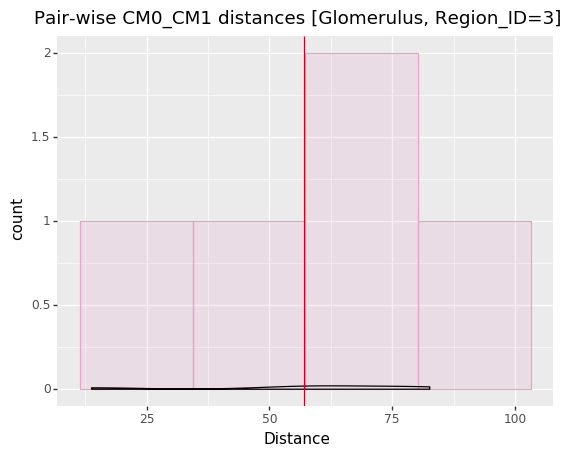

<ggplot: (982994676)>

In [73]:
f = prf.loc[(prf['idx_1'] == 'CM0') & (prf['idx_2'] == 'CM1')]

avg_dist = f['Distance'].mean()

g = ggplot(f, aes(x='Distance')) + \
geom_histogram(color= '#e9a3c9', fill= '#e9a3c9', alpha=.2) + \
geom_density() + \
geom_vline(f, aes(xintercept='avg_dist'), color = '#ca0020') + \
labs(title='Pair-wise CM0_CM1 distances [Glomerulus, Region_ID=3]') 

#print(g + facet_wrap('~ Sorted', scales = "free"))


# g = ggplot(f, aes(x='Distance')) + \
# geom_histogram(aes(y='stat(density)'), color= '#018571', fill= '#80cdc1', alpha=.2) + \
# geom_density() + \

# labs(title='CM0_CM1')
 



# ggsave(filename='Glomerulus_RegionID_3_CM0_CM4.png', plot = g, 
#        path = '../Figures/ExpPHa07_1/')
g

In [38]:
avg_dist

1299.3982880109097

In [22]:
f.head()

,objID_1,objID_2,cord_1,cord_2,idx_1,idx_2,mask_1,mask_2,RID_1,RID_2,Distance,X1,Y1,X2,Y2
2564961,502,243,"(1874, 6550)","(2643, 5608)",CM0,CM1,Out,Out,0,0,603.092386,1874,6550,2643,5608
2564970,502,252,"(1874, 6550)","(2789, 5699)",CM0,CM1,Out,Out,0,0,619.727605,1874,6550,2789,5699
2564980,502,262,"(1874, 6550)","(2471, 5758)",CM0,CM1,Out,Out,0,0,491.887191,1874,6550,2471,5758
2564984,502,266,"(1874, 6550)","(2742, 5801)",CM0,CM1,Out,Out,0,0,568.601556,1874,6550,2742,5801
2564985,502,267,"(1874, 6550)","(2788, 5805)",CM0,CM1,Out,Out,0,0,584.807990,1874,6550,2788,5805


In [ ]:



# g = ggplot(final, aes(x='Distance')) + \
# geom_histogram(aes(y='stat(density)'), color= '#018571', fill= '#80cdc1', alpha=.2) + \
# geom_density() 
    
# print(g + facet_wrap('~ Sorted', nrow=4))

    
    
    
    
  

In [ ]:

p = gg.ggplot(f) + \
    gg.geom_point(gg.aes(x='X1', y='Y1'), size = 0.5, color = "#9ecae1") + \
    gg.xlab("X") + \
    gg.ylab("Y") + \
    gg.ggtitle("Distribution of Cell types in a tissue space") + \
    gg.geom_point(gg.aes(x='X2', y='Y2'), size = 0.5, color = "#de2d26")
   


    

#ggsave(filename='cell_classification.png', plot = p, 
       #path = '/Users/habbasi/Desktop/012120_Halo_outputs/Figures')



In [ ]:
distlist = [15, 25, 50, 100, 250, 500, 1000, 2000]

for i, p in enumerate(distlist):
    
    f2 = f.loc[final['Distance'] <= p]
    g = gg.ggplot(f2) + \
    gg.geom_point(gg.aes(x='X1', y='Y1'), size = 0.5, color = "#9ecae1") + \
    gg.xlab("X") + \
    gg.ylab("Y") + \
    gg.labs(title= 'Distance_' +  str(p) + 'um') + \
    gg.geom_point(gg.aes(x='X2', y='Y2'), size = 0.5, color = "#de2d26") 
    ggsave(filename=str(p)+'.png', plot = g, 
       path = '../Figures/')
    
   


    







In [ ]:
# %reload_ext rpy2.ipython
# %R -i new

In [ ]:
# %reload_ext rpy2.ipython
# %R -i data

# from rpy2.robjects.packages import importr
# import rpy2.robjects as ro

# stats = importr('stats')
# base = importr('base')
# tidy = importr('tidyverse')
# akima = importr('akima')


# data.to_csv('../Data/data.csv')

In [ ]:
# data_anno = 

# for i, p in enumerate(labels):
#         poly = d[d.Annotation == str(p)]
#         row, col = polygon(np.array(poly.X), np.array(poly.Y))
# #         plt.plot(row, col)
# #         plt.show()
#         mask = [m for m in zip(row, col)]
#         dt = [t for t in zip(data.X, data.Y)]
#         d_mask = Intersection(dt,mask)
#         dt_mask = pd.DataFrame(d_mask, columns=['X', 'Y'])
#         dt_mask['Mask'] = str(p)
#         data_anno.append(dt_mask)